(sec_what_is)=

# What is a tree sequence?

A *succinct tree sequence*, or tree sequence for short, represents the relationships
between a set of DNA sequences. Tree sequences are based on fundamental biological
principles of inheritance, DNA duplication and recombination; they can be created by
[simulation](https://tskit.dev/software/#simulate) or by
[inferring relationships from genetic variation](https://tskit.dev/software/#infer).

Tree sequences provide an efficient way of storing genetic data, and enable powerful
analysis of millions of whole genomes. Plots (a) and (b) summarize results presented
[further](plot_storing_everyone) [down](plot_incremental_calculation) this tutorial.

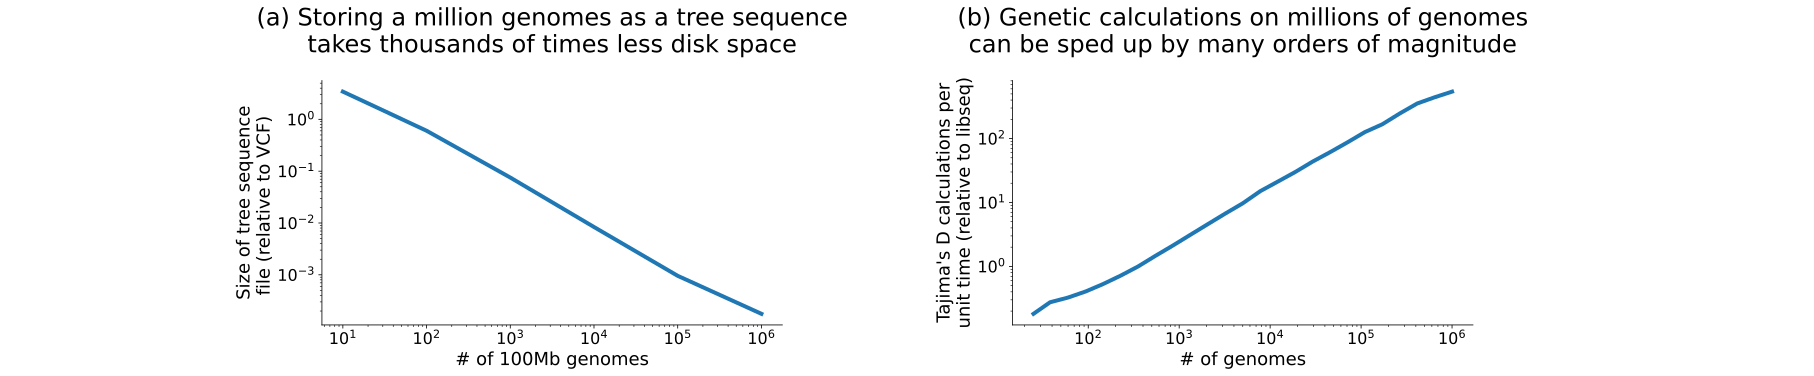

In [1]:
from IPython.display import SVG, set_matplotlib_formats
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
set_matplotlib_formats('svg')

data1 = np.genfromtxt("data/storing_everyone.csv", delimiter=",", usecols=np.arange(1,12), names=True)
data2 = np.genfromtxt("data/benchmarks_without_copy_longer_genome.txt", encoding=None, names=True, dtype=None)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 4.5))
fig.subplots_adjust(wspace=0.5, left=0, right=1)
keep = data1['sample_size'] <= 1e6
x, y = data1['sample_size'][keep], data1['tsk_fit'][keep]/data1['vcf_fit'][keep]
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.loglog(x, y, c="C0", linewidth=4)
ax1.set_xlabel('# of 100Mb genomes', fontsize=18)
ax1.set_ylabel('Size of tree sequence\nfile (relative to VCF) ', fontsize=18)
ax1.tick_params(axis="both", labelsize=16)

txt = ax1.text(0.5, 1.3, "(a) Storing a million genomes as a tree sequence takes thousands of times less disk space",
    ha='center', va='top', transform=ax1.transAxes, wrap=True, size=24)
txt._get_wrap_line_width = lambda: 600

ts_time = {n: t for s, n, t in data2[['toolkit','nsam','seconds']] if s == 'tskit'}
libseq_time = {n: t for s, n, t in data2[['toolkit','nsam','seconds']] if s == 'libseq'}
x = np.unique(list(ts_time.keys()) + list(libseq_time.keys()))
y = np.array([libseq_time[time]/ts_time[time] for time in x])
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.loglog(x, y, linewidth=4)
ax2.set_xlabel("# of genomes", fontsize=18)
ax2.set_ylabel("Tajima's D calculations per\nunit time (relative to libseq)", fontsize=18)
ax2.tick_params(axis="both", labelsize=16)
txt = ax2.text(0.5, 1.3, "(b) Genetic calculations on millions of genomes can be sped up by many orders of magnitude",
    ha='center', va='top', transform=ax2.transAxes, wrap=True, size=24
)    
txt._get_wrap_line_width = lambda: 600
plt.show()

As the name suggests, the simplest way to think
about a tree sequence is as a collection of "local trees" --- i.e. trees located at different
points along the chromosome. Here's a tiny example based on ten genomes,
$\mathrm{a}$ to $\mathrm{j}$, spanning a short 1kb chromosome.

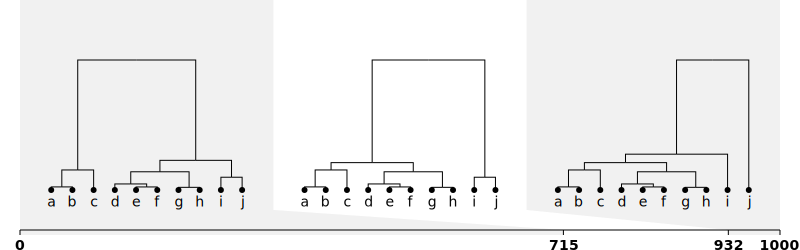

In [2]:
import string
import msprime
from IPython.display import SVG

seed = 3096  # chosen to create a nice example simulation
ts = msprime.sim_ancestry(5, population_size=1e4, sequence_length=1000,
    recombination_rate=1e-8, random_seed=seed)
# Extra code to label and order the tips alphabetically rather than numerically
genome_order = [n for n in ts.first().nodes(order="minlex_postorder") if ts.node(n).is_sample()]
labels = {n:string.ascii_lowercase[i] for i, n in enumerate(genome_order)}
style1 = ".node:not(.sample) > .sym {visibility: hidden;}"  # hide internal tree nodes
sz = (800, 250)  # size of the plot, slightly larger than the default

SVG(ts.draw_svg(size=sz, node_labels=labels, style=style1))

For almost three quarters of the chromosome, from the
start until position 715, the relationships between the ten genomes are shown by
the first tree. The second tree shows the relationships between positions 715 and 932,
and the third from position 932 to the end.

Multiple trees are needed because of genetic recombination, which causes
different regions of the chromosome to have different histories. Together, the sequence
of trees describe the full ancestry, or *genetic genealogy* of our 10 genomes.

(sec_what_is_dna_data)=

## An efficient encoding of DNA data

A tree sequence can be used to describe patterns of genetic variation by combining the
trees with a knowledge of where *mutations* occur on their branches. Here's how that
might look in our simple example:

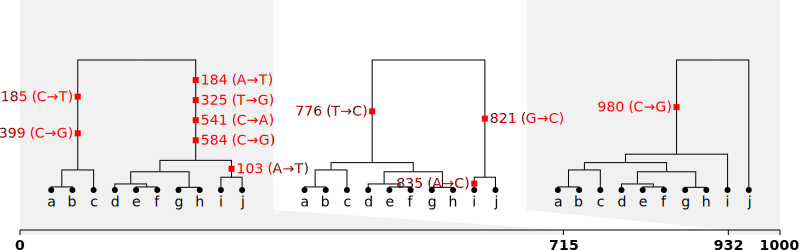

In [3]:
seed = 3
mutated_ts = msprime.sim_mutations(ts, rate=1e-7, random_seed=seed)

mut_labels = {}  # An array of labels for the mutations, listing position & allele change
l = "{:g} ({}→{})"
for mut in mutated_ts.mutations():  # This entire loop is just to make pretty labels
    site = mutated_ts.site(mut.site)
    older_mut = mut.parent >= 0  # is there an older mutation at the same position?
    prev = mutated_ts.mutation(mut.parent).derived_state if older_mut else site.ancestral_state
    mut_labels[mut.id] = l.format(site.position, prev, mut.derived_state)

SVG(mutated_ts.draw_svg(size=sz, node_labels=labels, mutation_labels=mut_labels, style=style1))

The trees tell us that, for example, the final mutation (at position 980) is inherited
by genomes $\mathrm{a}$ to $\mathrm{i}$. These genomes must have a *G* at that position,
compared to the original value of *C*. In other words, once we know the ancestry, placing
a relatively small number of mutations is enough to explain all the observed genetic
variation. Here's the result from all 11 variable sites in our example:

In [4]:
haplotypes = ["   ".join(h) for h in mutated_ts.haplotypes()]
print("Position  " + " ".join(str(int(s.position)) for s in mutated_ts.sites()))
print("\n".join(sorted([f"Genome {labels[i]}:  {h}" for i, h in enumerate(haplotypes)])))

Position  103 184 185 325 399 541 584 776 821 835 980
Genome a:  A   A   T   T   G   C   C   C   G   A   G
Genome b:  A   A   T   T   G   C   C   C   G   A   G
Genome c:  A   A   T   T   G   C   C   C   G   A   G
Genome d:  A   T   C   G   C   A   G   C   G   A   G
Genome e:  A   T   C   G   C   A   G   C   G   A   G
Genome f:  A   T   C   G   C   A   G   C   G   A   G
Genome g:  A   T   C   G   C   A   G   C   G   A   G
Genome h:  A   T   C   G   C   A   G   C   G   A   G
Genome i:  T   T   C   G   C   A   G   T   C   C   G
Genome j:  T   T   C   G   C   A   G   T   C   A   C


This approach scales effectively to millions of genomes and chromosomes of
hundreds of megabases in length. The ability to deal with huge datasets comes down to
one key feature of genomic data: adjacent trees along a chromosome are highly correlated,
that is, they *share structure*. In our example this becomes evident
if we highlight the branches ("edges" in tree sequence terminology) that remain
unchanged between the first and the second tree.

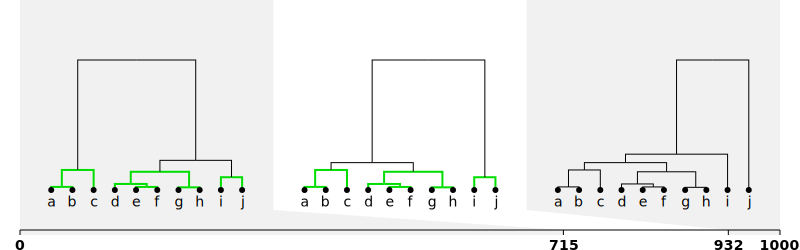

In [5]:
# Highlight certain edges in certain trees. Other visualization possibilities in tutorials/viz.html
kept_edges = [e for e in ts.edges() if e.left==0 and e.right>ts.breakpoints(True)[1]]
style3 = (
    ",".join(f"#svg1 .tree:not(.t2) .node.a{e.parent}.n{e.child} > .edge" for e in kept_edges)
    + "{stroke:#00DD00; stroke-width: 2px}"
    + style1)
SVG(ts.draw_svg(size=sz, root_svg_attributes={'id':'svg1'}, node_labels=labels, style=style3))

<!-- Another way to think about shared structure is to notice that the second tree can be
formed by a simple rearrangement of the first tree. This can be done by simply switching
the centre group of five genomes, labelled $\mathrm{d}$ to $\mathrm{h}$, next to
$\mathrm{a}+\mathrm{b}+\mathrm{c}$. Similarly, the third tree just involves a single
adjustment: the movement of genome $\mathrm{i}$ away from being the closest relative of
$\mathrm{j}$. These sort of small rearrangements are typical of how genetic relationships
change along chromosomes, in both simulated and real datasets. -->
<!-- possible link here to a tutorial which talks about SPRs -->

A branch can be shared by many adjacent trees, but is stored just once in the tree
sequence. For large datasets this is a great saving, because typically each tree-change
affects only a few branches at a time, regardless of the tree size.
Here's the take-home message:

```{epigraph}
Tree sequences are efficient because they don't store each tree separately
```

Extending the analysis plotted at the start of this page, this efficiency is predicted
to extend to the case of simulating chromosomes for every human on the planet. Moreover,
the advantage of using tree sequences persists even when compared to compressed versions
of the standard VCF storage format (original published data
[here](https://www.nature.com/articles/s41588-019-0483-y/figures/1)). Simply by virtue
of the reduced file size, simulated genome data stored as a tree sequence can be several
orders of magnitude faster to process than other storage formats.

(plot_storing_everyone)=

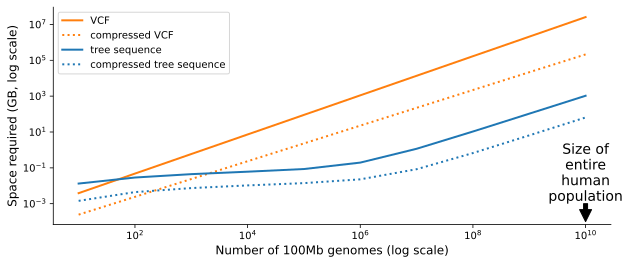

In [6]:
x = data1['sample_size']
fig, ax1 = plt.subplots(1, figsize=(10, 4))
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)

plt.loglog(x,  data1['vcf_fit'], c="C1", label="VCF", linewidth=2)
plt.loglog(x,  data1['vcfz_fit'], c="C1", label="compressed VCF", linewidth=2, linestyle=":")

plt.loglog(x, data1['tsk_fit'], c="C0", label="tree sequence", linewidth=2)
plt.loglog(x, data1['tskz_fit'], c="C0", label="compressed tree sequence", linewidth=2, linestyle=":")

plt.xlabel('Number of 100Mb genomes (log scale)', fontsize=12)
plt.ylabel('Space required (GB, log scale)', fontsize=12)
plt.text(max(x), 0.001, 'Size of\nentire\nhuman\npopulation', ha="center", va="bottom", size=14)
plt.annotate('', xy=(max(x), 0.0001), xytext=(max(x), 0.001), 
            arrowprops=dict(facecolor='black', shrink=0))
plt.legend()
plt.show()

(sec_what_is_ancestry)=

## A record of genetic ancestry

Often, we're not interested so much in the DNA sequence data as the genetic ancestry
itself (e.g. see [this summary](https://www.nature.com/articles/s41588-019-0492-x)). For
instance, tree sequences can be used to determine the origin and age of variants under
selection, to capture the spatial structure of populations, or to uncover the effects of
hybridization and admixture in the past.

```{todo}
Insert illustration of the above, e.g. use of branch length calculations rather than
variants using colours for different branch lengths, or possibly a simple view of a
tree sequence over geographical space.
```


A major benefit of "tree sequence thinking" is the close relationship between the
tree sequence and the underlying biological processes that produced
the genomes in the first place. For example, each branch point in one of the trees above
represents a most recent common ancestor (MRCA), in other words a genome which existed at
a specific time in the past. 

```{todo}
The tree sequence format gives us access to those ancestral genomes: insert diagram of
reconstructed (partial) ancestral haplotypes
```

We can mark these extra "ancestral genomes" on our picture,
although is helpful to distinguish them from the *sampled* genomes
($\mathrm{a}$ to $\mathrm{j}$) which we have measured more directly. Here we'll plot
the MRCA genomes as circular nodes, rather than the squares we have used previously.

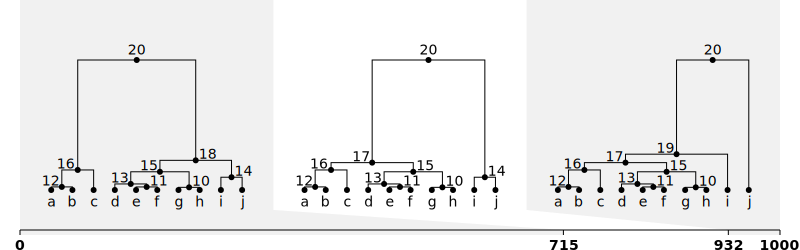

In [7]:
all_labels = {n:n for n in range(ts.num_nodes)}
all_labels.update(labels)  # For consistency, keep letters for the sample nodes
style2 = "#svg2 .node > .sym {visibility: visible;}"  # force-show all nodes: not normally needed
SVG(ts.draw_svg(size=sz, root_svg_attributes={'id':'svg2'}, node_labels=all_labels, style=style2))

```{note}
For clarity in these examples, we have been relabelling the sample genomes as
$\mathrm{a}$ to $\mathrm{j}$, and for the rest of this page we will continue to do so.
However, in standard tree sequences, all the genomes (which are referred to as "nodes"),
including the samples, are numbered sequentially from 0.
```

```{todo}
Mention ARGs in passing and link out to the ARG tutorial.
<!-- Somewhere we should explain *why* trees change along the genome, and it
would be good to mention ARGs in passing somewhere. We previously had too much
detail, though:

The change from one tree to another is also biologically meaningful. It indicates that
one or more recombination events occured at this genomic location in the past. Note,
however, that for efficiency reasons and more, neither the recombination event itself
nor the branches on which it occurred are usually present in a tree sequence, although
it is possible to incorporate them via simulation (see the ARG tutorial). -->
```

(sec_what_is_analysis)=

## An efficient analysis framework


```{todo}
Introduction: algorithms on trees are known to be efficient (phylogenetics). We
extend these to multiple correlated trees. Mention "dynamic programming" in passing
```

Statistical measures of genetic variation can be thought of as a calculation combining
the local trees with the mutations on each branch (or, often preferably, the length of the
branches: see [this summary](https://www.genetics.org/content/genetics/215/3/779)).
Because a tree sequence is built on a set of small branch changes along the chromosome,
statistical calculations can often be updated incrementally as we
move along the genome, without having to perform the calculation *de-novo* on each tree.
When perfoming calculations on large datasets, this can result in speed-ups of many
orders of magnitude, as in this example of calculating Tajima's D (from
[this source](https://www.genetics.org/content/215/3/779#F9))

(plot_incremental_calculation)=

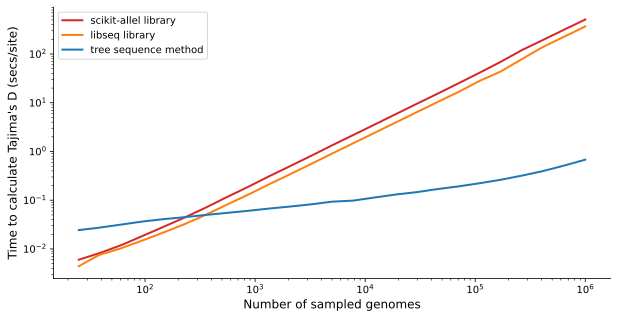

In [8]:
ts_time = np.array([[n,t] for s, n, t in data2[['toolkit','nsam','seconds']] if s == 'tskit'])
ska_time = np.array([[n, t] for s, n, t in data2[['toolkit','nsam','seconds']] if s == 'allel'])
libseq_time = np.array([[n, t] for s, n, t in data2[['toolkit','nsam','seconds']] if s == 'libseq'])
fig, ax1 = plt.subplots(1, figsize=(10, 5))
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.loglog(ska_time[:,0], ska_time[:,1], c="C3", linewidth=2, label="scikit-allel library")
ax1.loglog(libseq_time[:,0], libseq_time[:,1], c="C1", linewidth=2, label="libseq library")
ax1.loglog(ts_time[:,0], ts_time[:,1], c="C0", linewidth=2, label="tree sequence method")
ax1.set_ylabel("Time to calculate Tajima's D (secs/site)", fontsize=12)
ax1.set_xlabel("Number of sampled genomes", fontsize=12)
plt.legend()
plt.show()

```{todo}
Very brief discussion of efficient counting of topologies, i.e. the combinatorics module
```

Summary of this subsection:

```{epigraph}
Genetic calculations involve iterating over trees, which is highly efficient in ``tskit`` 
```

## Further reading

* How is a tree sequence stored: details in the
  [data structures](sec_data_structures) tutorial
* The tree sequence philosophy. biological underpinnings and SPRs (to do)